# Proyecto detector de Spam desde URL


Paso 1:

Cargue su conjunto de datos y realice las transformaciones necesarias en su variable de destino.

In [91]:
!pip install pandas
!pip install regex
!pip install matplotlib
!pip install sklearn
!pip install wordcloud
!pip install seaborn


In [92]:

import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import model_selection, svm
from sklearn.metrics import classification_report, accuracy_score
from scipy import stats
import seaborn as sns; sns.set()
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


In [93]:
# Extraigo los datos

df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [94]:
# Observo las primeras filas

df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [95]:
# EDA: elimino los duplicados
print("spam count: " +str(len(df.loc[df.is_spam==True])))
print("not spam count: " +str(len(df.loc[df.is_spam==False])))
print(df.shape)
df['is_spam'] = df['is_spam'].astype(int)

df = df.drop_duplicates()
df = df.reset_index(inplace = False)[['url','is_spam']]

spam count: 696
not spam count: 2303
(2999, 2)


In [96]:
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


Paso 2:

Utilice técnicas de PNL para preprocesar los datos. Aquí hay otra idea sobre cómo excluir algunas palabras creando nuevas columnas:

In [97]:
clean_desc = []

for w in range(len(df.url)):
    desc = df['url'][w].lower()
    
    #remuevo las puntuaciones
    desc = re.sub('[^a-zA-Z]', ' ', desc)
    
    #remuevo los caracteres 
    desc=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)
    
    #remuevo los digitos y caracteres especiales
    desc=re.sub("(\\d|\\W)+"," ",desc)

    #remuevo los https
    desc=re.sub(r'(https://www|https://)', ' ',desc)

    #remuevo los https
    desc=re.sub(r"https", " " ,desc)

    #remuevo los www
    desc=re.sub(r"www", " " ,desc)
    
    clean_desc.append(desc)

#
df['url'] = clean_desc

df.head()

,url,is_spam
0,briefingday us list manage com unsubscribe,1
1,hvper com,1
2,briefingday com m v n i f,1
3,briefingday com n m commentform,0
4,briefingday com fan,1


In [98]:
stop_words = ['is','you','your','and', 'the', 'to', 'from', 'or', 'I', 'for', 'do', 'get', 'not', 'here', 'in', 'im', 'have', 'on', 're', 'new', 'subject']

Paso 3:

Utilice la máquina Support Vector para crear un clasificador de spam de URL.

In [99]:
vector = CountVectorizer().fit_transform(df['url'])

In [100]:
# Divido mis datos de entrenamiento y validacion

X_train, X_test, y_train, y_test = train_test_split(vector, df['is_spam'], stratify = df['is_spam'], random_state = 2207)

In [101]:
classifier = SVC(C = 1.0, kernel = 'linear', gamma = 'auto')

In [102]:
# Veamos los resultados del reporte estadistico
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       532
           1       0.65      0.59      0.62        61

    accuracy                           0.93       593
   macro avg       0.80      0.78      0.79       593
weighted avg       0.92      0.93      0.92       593



El modelo muestra una precision de un 95%, el 89% de los datos no es spam, mientras que el 10,28% si lo es, ahora veamos usando GridSearch para mejorar nuestros parametros

In [103]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(random_state=1234),param_grid,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.3s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, k

GridSearchCV(estimator=SVC(random_state=1234),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [104]:
print(grid.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [105]:
print(grid.best_estimator_)

SVC(C=10, gamma=0.1, random_state=1234)


In [106]:
model = grid.best_estimator_
yfit = model.predict(X_test)
print(classification_report(y_test, yfit))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       532
           1       0.75      0.54      0.63        61

    accuracy                           0.93       593
   macro avg       0.85      0.76      0.80       593
weighted avg       0.93      0.93      0.93       593



Se observa un aumento en el recall, con un 98% para los no spam

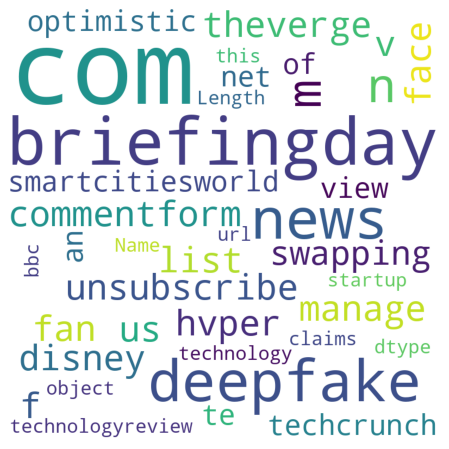

In [109]:
# veamos una nube de palabras con los titulos de mis url

text = ' '.join([i for i in df.url])
wordcloud = WordCloud(width = 800, height = 800, background_color = 'white', stopwords = stop_words, max_words = 1000
                      , min_font_size = 20).generate(str(df['url']))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

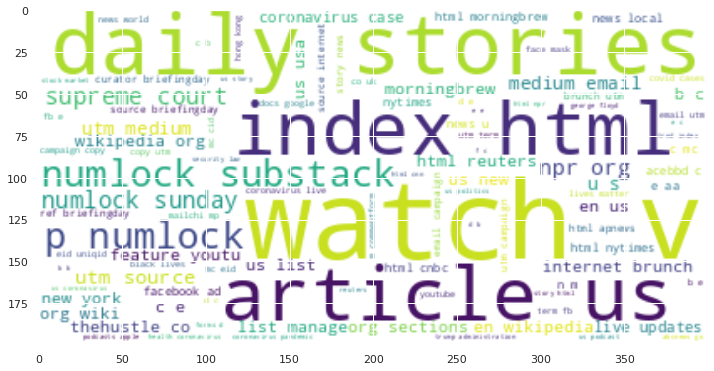

In [110]:
# construiremos un bigrama con el contenido
wordCloud_bg = WordCloud(collocation_threshold=2, collocations=True, max_words=100 , background_color='White').generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordCloud_bg, interpolation='bilinear')
plt.show()


Paso 4:

Como siempre, use su computadora portátil para experimentar y asegúrese de obtener los resultados que desea.